## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [109]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk.tokenize import RegexpTokenizer
from sklearn.ensemble import RandomForestClassifier
import warnings
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/albertcc/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/albertcc/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [110]:
data = pd.read_csv('data/tweets.csv')
data.columns = ['text', 'device', 'emotion']

In [111]:
data.head()

,text,device,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [112]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     9092 non-null   object
 1   device   3291 non-null   object
 2   emotion  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [113]:
data['emotion'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

### Data Cleaning

In [114]:
### Dropping 'I can't tell' and 'Other' rows

data = data[data['emotion'] != "I can't tell"]

### Dropping blank 'text' rows

data = data.dropna(subset=['text'])

In [115]:
data['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

In [116]:
data['device'].value_counts(normalize=True)

iPad                               0.287020
Apple                              0.200792
iPad or iPhone App                 0.143205
Google                             0.130713
iPhone                             0.090189
Other Google product or service    0.088970
Android App                        0.024680
Android                            0.023766
Other Apple product or service     0.010664
Name: device, dtype: float64

### Clean text data using functions

In [117]:
### Creating a function that removes words that begin with @, as mentions would not be important in determining the emotion of a tweet

def remove_at(text):
    text = text.split()
    text = [word for word in text if not word.startswith('@')]
    text = ' '.join(text)
    return text

### Creating a function that makes all text lowercase for further analysis

def lower_case(text):
    text = text.lower()
    return text

### Creating a function that removes all punctuation with the exception of ! and ? as they may be important in determining the emotion of a tweet

def remove_punctuation(text):
    text = text.split()
    text = [word for word in text if not word.startswith('!') and not word.startswith('?')]
    text = ' '.join(text)
    return text

### Creating a function that removes stopwords from a specified list of stopwords

custom_stop_words = ['in','of','at','a','the']

def remove_stopwords(text):
    text = text.split()
    text = [word for word in text if word not in custom_stop_words]
    text = ' '.join(text)
    return text

### Creating a function that removes non-ASCII characters

def remove_characters(text):
    text = text.encode('ascii', 'ignore').decode('ascii')
    return text

### Creating a function that lemmatizes words

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text)
    return text

### Creating a function takes the tokenized text and returns a string of words

def tokenize_to_string(text):
    tknzr = TweetTokenizer()
    text = tknzr.tokenize(text)
    text = ' '.join(text)
    return text

### Creating a function that removes '#SXSW' of any case type from the text

def remove_sxsw(text):
    text = text.split()
    text = [word for word in text if not word.startswith('#sxsw') and not word.startswith('#SXSW')]
    text = ' '.join(text)
    return text

### Creating a function that combines all of the above functions

def clean_text(text):
    text = remove_at(text)
    text = lower_case(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = remove_characters(text)
    text = lemmatize(text)
    text = tokenize_to_string(text)
    text = remove_sxsw(text)
    return text

In [118]:
### Testing out the function with some random text
clean_text('Hello this is the test text THAT I have #sb #sxsw eee @!twitter')

'hello this is test text that i have #sb eee'

### Feature Engineering

In [119]:
apple = ['iPad', 'Apple', 'iPad or iPhone App', 'iPhone', 'Other Apple product or service']
google = ['Google', 'Other Google product or service', 'Android App', 'Android']

In [120]:
### Creating a new column for google vs. apple vs. unknown

data['device_type'] = np.where(data['device'].isin(google), 'Google', 
                    np.where(data['device'].isin(apple), 'Apple', 
                             'Unknown'))

In [121]:
### Creating a new column for 'Google' and 'Apple' based on device type and key words in the 'text' column

google_key_words = ["Google", "Android", "Pixel", "Circles", "Droid", "Galaxy S", "Realtime", "Maps", "Google Maps", "Circle" ]

apple_key_words = ["Apple", "iPhone", "iPad", "Mac", "iMac", "iPod", "iTunes", "iWatch", "iMessage", "iCloud", "iBook", "iMac", "app_store", "app store", "ios", "ios4", "ios4.1", "ios4.2", "iphone app", "3g", "ios"]
                  
data['Google'] = np.where(data['device_type'] == 'Google', True, 
               np.where(data['text'].str.lower().str.contains('|'.join(google_key_words), case=False), True, 
               False))

data['Apple'] = np.where(data['device_type'] == 'Apple', True,
              np.where(data['text'].str.lower().str.contains('|'.join(apple_key_words), case=False), True,
              False))

### Create new column 'both' that is true if both Google and Apple are true

data['both'] = np.where((data['Google'] == True) & (data['Apple'] == True), True, False)

### Dropping rows where both Google and Apple are true and where Google and Apple are both false

data = data[data['both'] == False]
data = data[data['Google'] != data['Apple']]
data = data.drop(columns=['both'])

In [122]:
data

,text,device,emotion,device_type,Google,Apple
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,False,True
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,False,True
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple,False,True
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple,False,True
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,True,False
...,...,...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple,False,True
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,Unknown,True,False
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,Unknown,True,False
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,Unknown,False,True


In [123]:
data[data['device_type']=='Apple']['emotion'].value_counts()

Positive emotion                      1898
Negative emotion                       381
No emotion toward brand or product      65
Name: emotion, dtype: int64

In [124]:
data[data['device_type']=='Google']['emotion'].value_counts()

Positive emotion                      692
Negative emotion                      122
No emotion toward brand or product     26
Name: emotion, dtype: int64

### Vader Score sentiment

In [125]:
### Creating new columns in the dataframe which append 'pos', 'neg', and 'neu' using VADER sentiment analysis

sid = SentimentIntensityAnalyzer()
data['sentiment'] = data['text'].apply(lambda x: sid.polarity_scores(x))
data = pd.concat([data.drop(['sentiment'], axis=1), data['sentiment'].apply(pd.Series)], axis=1)

In [126]:
### Creating an 'emphasis' column that scores how many exclamation points, question marks, and capital letters are in the text

data['emphasis'] = data['text'].apply(lambda x: sum([1 for char in x if char in ['!', '?']])) + \
                 data['text'].apply(lambda x: sum([1 for char in x if char.isupper()]))

In [127]:
data

,text,device,emotion,device_type,Google,Apple,neg,neu,pos,compound,emphasis
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,Apple,False,True,0.203,0.797,0.000,-0.6800,16
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,False,True,0.000,0.576,0.424,0.9100,11
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple,False,True,0.000,1.000,0.000,0.0000,7
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple,False,True,0.000,0.663,0.337,0.7269,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,True,False,0.000,0.796,0.204,0.6249,14
...,...,...,...,...,...,...,...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,Apple,False,True,0.000,1.000,0.000,0.0000,5
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,Unknown,True,False,0.208,0.792,0.000,-0.4939,4
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,Unknown,True,False,0.000,1.000,0.000,0.0000,9
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,Unknown,False,True,0.109,0.891,0.000,-0.4019,10


In [128]:
data[data['pos'] > 0.1]

,text,device,emotion,device_type,Google,Apple,neg,neu,pos,compound,emphasis
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,False,True,0.000,0.576,0.424,0.9100,11
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,Apple,False,True,0.000,0.663,0.337,0.7269,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,True,False,0.000,0.796,0.204,0.6249,14
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,Google,True,False,0.000,0.822,0.178,0.6369,8
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,Apple,False,True,0.000,0.691,0.309,0.7712,8
...,...,...,...,...,...,...,...,...,...,...,...
9072,@mention your iPhone 4 cases are Rad and Ready...,iPhone,Positive emotion,Apple,False,True,0.103,0.752,0.145,0.2225,7
9073,At #SXSW your iphone charger is your best friend.,NaN,No emotion toward brand or product,Unknown,False,True,0.000,0.486,0.514,0.8126,5
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,Apple,False,True,0.000,0.673,0.327,0.7783,4
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,Apple,False,True,0.000,0.409,0.591,0.8264,8


In [129]:
data[data['emotion'] == "Positive emotion"]

,text,device,emotion,device_type,Google,Apple,neg,neu,pos,compound,emphasis
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,Apple,False,True,0.000,0.576,0.424,0.9100,11
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,Apple,False,True,0.000,1.000,0.000,0.0000,7
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,Google,True,False,0.000,0.796,0.204,0.6249,14
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion,Google,True,False,0.000,0.822,0.178,0.6369,8
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion,Apple,False,True,0.000,0.691,0.309,0.7712,8
...,...,...,...,...,...,...,...,...,...,...,...
9072,@mention your iPhone 4 cases are Rad and Ready...,iPhone,Positive emotion,Apple,False,True,0.103,0.752,0.145,0.2225,7
9077,@mention your PR guy just convinced me to swit...,iPhone,Positive emotion,Apple,False,True,0.000,0.673,0.327,0.7783,4
9079,&quot;papyrus...sort of like the ipad&quot; - ...,iPad,Positive emotion,Apple,False,True,0.000,0.409,0.591,0.8264,8
9085,I've always used Camera+ for my iPhone b/c it ...,iPad or iPhone App,Positive emotion,Apple,False,True,0.000,1.000,0.000,0.0000,14


### Train Test Split

In [130]:
### Performing a train/test split

X = data.drop('emotion', axis=1)
y = data['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

## Modeling

### First Simple Model - Count Vectorizer / Decision Tree / No Features

In [131]:
### Performing a train test split on the data, only including the 'text' and 'emotion' columns

X1 = data['text']
y1 = data['emotion']

### Adding the tokenizer to the 'text' column in the X features

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X1, y1, test_size=0.2, random_state=1337)

X_train_1 = X_train_1.apply(clean_text)

In [132]:
X_train_1

2687    google map app save my life on regular basis r...
5028    rt google to launch major new social network c...
3215    nice being able to use just usb charging cord ...
7888    so jealous who is team #android event #android...
796     google to launch major new social network call...
                              ...                        
3739    tried to initiate carpooling ridonkulous taxi ...
1458         oh snap ! ! ! an 80 party hosted by google !
992     brown paper on window a line grows popup apple...
218                hobo with shotgun iphone game { link }
3718    google going circle about sn rt we're not laun...
Name: text, Length: 6354, dtype: object

Training Accuracy Score: 0.43877872206484103
Validation Accuracy Score: 0.46113271836299774


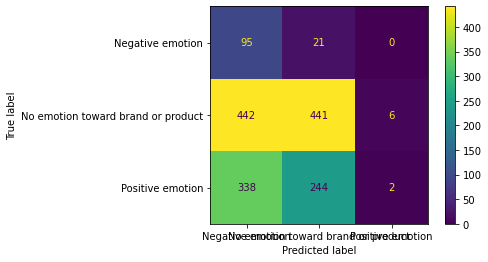

In [133]:
### Creating an imbpalance-learn pipeline that uses SMOTE to oversample the minority classes and then uses a Decision Tree to predict the emotion of a tweet

baseline = imbpipeline([
    ('cvec', CountVectorizer(encoding = 'iso-8859-1', lowercase = False)),
    ('smote', SMOTE(sampling_strategy='minority', random_state=1337)),
    ('dt', DecisionTreeClassifier(random_state=1337, max_depth=5))
])

### Fitting the pipeline to the training data and printing the training and validation accuracy scores

baseline.fit(X_train_1, y_train_1)
print('Training Accuracy Score:', baseline.score(X_train_1, y_train_1))
print('Validation Accuracy Score:', cross_val_score(baseline, X_train_1, y_train_1, cv=5).mean())

### Import confusion_matrix and print the confusion matrix for the validation data

from sklearn.metrics import confusion_matrix

y_pred_1 = baseline.predict(X_test_1)
cm = confusion_matrix(y_test_1, y_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=baseline.classes_)
disp.plot()

In [134]:
X1.shape

(7943,)

In [135]:
y1.shape

(7943,)

In [136]:
X_train_1.shape

(6354,)

In [137]:
y_train_1.shape

(6354,)

In [138]:
X1.head()

0    .@wesley83 I have a 3G iPhone. After 3 hrs twe...
1    @jessedee Know about @fludapp ? Awesome iPad/i...
2    @swonderlin Can not wait for #iPad 2 also. The...
3    @sxsw I hope this year's festival isn't as cra...
4    @sxtxstate great stuff on Fri #SXSW: Marissa M...
Name: text, dtype: object

In [139]:
y1.head()

0    Negative emotion
1    Positive emotion
2    Positive emotion
3    Negative emotion
4    Positive emotion
Name: emotion, dtype: object

**Second Model - Count Vectorizer / Logistic Regression / Added Sentiment and Emphasis Score**

In [140]:
### Performing a train test split on the data, including 'text', VADER scores, and 'emphasis' columns
X2 = data.drop(columns=['emotion', 'device', 'device_type', 'Google', 'Apple'])
y2 = data['emotion']

### Performing a train test split on the X2 and Y2 data

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, test_size=0.2, random_state=1337)


### Applying the tokenizer to the 'text' column in the X features

X_train_2['text'] = X_train_2['text'].apply(clean_text)

<ipython-input-140-8a0307d2a526>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_2['text'] = X_train_2['text'].apply(clean_text)


In [141]:
X_train_2

,text,neg,neu,pos,compound,emphasis
2687,google map app save my life on regular basis r...,0.000,1.000,0.000,0.0000,4
5028,rt google to launch major new social network c...,0.000,1.000,0.000,0.0000,12
3215,nice being able to use just usb charging cord ...,0.000,0.882,0.118,0.4215,11
7888,so jealous who is team #android event #android...,0.208,0.792,0.000,-0.6663,7
796,google to launch major new social network call...,0.000,1.000,0.000,0.0000,10
...,...,...,...,...,...,...
3739,tried to initiate carpooling ridonkulous taxi ...,0.055,0.945,0.000,-0.1027,3
1458,oh snap ! ! ! an 80 party hosted by google !,0.000,0.699,0.301,0.5951,13
992,brown paper on window a line grows popup apple...,0.000,1.000,0.000,0.0000,13
218,hobo with shotgun iphone game { link },0.000,1.000,0.000,0.0000,17


In [142]:
### Tokenize the training data with simple split of words, flattening to prepare for vectorization
X_train_2['text'] = X_train_2['text'].apply(lambda x: x.split())
X_train_2['text'] = X_train_2['text'].map(' '.join)

<ipython-input-142-e980c4ff8f28>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_2['text'] = X_train_2['text'].apply(lambda x: x.split())
<ipython-input-142-e980c4ff8f28>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_2['text'] = X_train_2['text'].map(' '.join)


In [144]:
X_train_2['text']

2687    google map app save my life on regular basis r...
5028    rt google to launch major new social network c...
3215    nice being able to use just usb charging cord ...
7888    so jealous who is team #android event #android...
796     google to launch major new social network call...
                              ...                        
3739    tried to initiate carpooling ridonkulous taxi ...
1458         oh snap ! ! ! an 80 party hosted by google !
992     brown paper on window a line grows popup apple...
218                hobo with shotgun iphone game { link }
3718    google going circle about sn rt we're not laun...
Name: text, Length: 6354, dtype: object

In [145]:
tfidf = TfidfVectorizer()
X_train_2 = tfidf.fit_transform(X_train_2['text'])

In [146]:
X_train_2

<6354x7650 sparse matrix of type '<class 'numpy.float64'>'
	with 85872 stored elements in Compressed Sparse Row format>

In [99]:
lr = LogisticRegression(random_state=1337, max_iter=1000)
lr.fit(X_train_2, y_train_2)


LogisticRegression(max_iter=1000, random_state=1337)

In [100]:
print('Training Accuracy Score:', lr.score(X_train_2, y_train_2))

Training Accuracy Score: 0.8114573497009757


In [101]:
scores = cross_val_score(lr, X_train_2, y_train_2, cv=5)
print('Cross Validation Scores: ', scores)
print('Mean Cross Validation Score: ', scores.mean()) 

Cross Validation Scores:  [0.66640441 0.66797797 0.68214005 0.6711251  0.66929134]
Mean Cross Validation Score:  0.6713877720438368


In [96]:
lr.coef_

array([[-6.08698736e-02,  1.93253271e+00, -2.24291972e-03, ...,
         2.42605556e+00, -1.22236059e+00, -2.29518225e-01],
       [ 7.07827868e+00,  3.88610129e+00,  2.20042911e-02, ...,
         1.72041048e+00,  3.12939668e+00,  1.49555630e+00],
       [-7.01740881e+00, -5.81863400e+00, -1.97613714e-02, ...,
        -4.14646604e+00, -1.90703608e+00, -1.26603808e+00]])

In [85]:
### Creating an imbpalance-learn pipeline that uses SMOTE to oversample the minority classes and then uses a Logistic Regression to predict the emotion of a tweet

# baseline2 = imbpipeline([
#      ('cvec', CountVectorizer(encoding = 'iso-8859-1', lowercase = False)),
#      ('smote', SMOTE(sampling_strategy='minority', random_state=1337)),
#      ('lr', LogisticRegression(random_state=1337, max_iter=1000))
#  ])

### Fitting the pipeline to the training data and printing the training and validation accuracy scores

# baseline2.fit(X_train_2, y_train_2.values.ravel())
# print('Training Accuracy Score:', baseline2.score(X_train_2, y_train_2))
# print('Validation Accuracy Score:', cross_val_score(baseline2, X_train_2, y_train_2, cv=5).mean())

ValueError: Found input variables with inconsistent numbers of samples: [6, 6354]

In [105]:
### Splitting the features into features and the target, including the 'text', sentiment columns, and emphasis columns as features

X3 = data[['text', 'compound', 'neg', 'neu', 'pos', 'emphasis']]
y3 = data['emotion']

### Performing a train test split on the data

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X3, y3, test_size=0.2, random_state=1337)

### TRAIN - Applying the clean_text function to the training data

X_train_3['text'] = X_train_3['text'].apply(clean_text)

### TRAIN - Tokenizing the training data with a simple split of words, and then flattening to prepare for vectorization

X_train_3['text'] = X_train_3['text'].apply(lambda x: x.split())
X_train_3['text'] = X_train_3['text'].map(' '.join)

### TRAIN - Vectorizing the training data using a TD-IDF Vectorizer

tfidf = TfidfVectorizer()
X_train_3 = tfidf.fit_transform(X_train_3['text'])

### TRAIN - Fit the training data to a Random Forest Classifier

rfc = RandomForestClassifier()
rfc.fit(X_train_3, y_train_3)

### VALIDATION - Perform a cross validation on the Random Forest Classifier

scores = cross_val_score(rfc, X_train_3, y_train_3, cv=5)
print('Cross Validation Scores: ', scores)
print('Mean Cross Validation Score: ', scores.mean()) 

<ipython-input-105-ea0690e854c2>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_3['text'] = X_train_3['text'].apply(clean_text)
<ipython-input-105-ea0690e854c2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_3['text'] = X_train_3['text'].apply(lambda x: x.split())
<ipython-input-105-ea0690e854c2>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

Cross Validation Scores:  [0.66719119 0.67427223 0.66168371 0.65145555 0.65354331]
Mean Cross Validation Score:  0.6616291964291247
